In [1]:
import os
import pandas as pd 
import numpy as np
import gc

# get data
filepath_2007_data = r'./data/matchups-2007_clean.csv'
filepath_2008_data = r'./data/matchups-2008_clean.csv'
filepath_2009_data = r'./data/matchups-2009_clean.csv'
filepath_2010_data = r'./data/matchups-2010_clean.csv'
filepath_2011_data = r'./data/matchups-2011_clean.csv'
filepath_2012_data = r'./data/matchups-2012_clean.csv'
filepath_2013_data = r'./data/matchups-2013_clean.csv'
filepath_2014_data = r'./data/matchups-2014_clean.csv'
filepath_2015_data = r'./data/matchups-2015_clean.csv'

df_2007 = pd.read_csv(filepath_2007_data)
df_2008 = pd.read_csv(filepath_2008_data)
df_2009 = pd.read_csv(filepath_2009_data)
df_2010 = pd.read_csv(filepath_2010_data)
df_2011 = pd.read_csv(filepath_2011_data)
df_2012 = pd.read_csv(filepath_2012_data)
df_2013 = pd.read_csv(filepath_2013_data)
df_2014 = pd.read_csv(filepath_2014_data)
df_2015 = pd.read_csv(filepath_2015_data)

df_2007 = df_2007.drop(columns=["game"])
df_2008 = df_2008.drop(columns=["game"])
df_2009 = df_2009.drop(columns=["game"])
df_2010 = df_2010.drop(columns=["game"])
df_2011 = df_2011.drop(columns=["game"])
df_2012 = df_2012.drop(columns=["game"])
df_2013 = df_2013.drop(columns=["game"])
df_2014 = df_2014.drop(columns=["game"])
df_2015 = df_2015.drop(columns=["game"])

combined_df = pd.concat([df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015], ignore_index=True)
del df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015
gc.collect()


0

In [2]:
combined_df.head()

,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,home_4,away_0,away_1,away_2,away_3,away_4,outcome
0,2007,LAL,PHO,0,Andrew Bynum,Lamar Odom,Luke Walton,Sasha Vujacic,Smush Parker,Boris Diaw,Kurt Thomas,Raja Bell,Shawn Marion,Steve Nash,-1
1,2007,LAL,PHO,6,Andrew Bynum,Lamar Odom,Luke Walton,Sasha Vujacic,Smush Parker,Amar'e Stoudemire,Leandro Barbosa,Raja Bell,Shawn Marion,Steve Nash,-1
2,2007,LAL,PHO,8,Lamar Odom,Luke Walton,Maurice Evans,Ronny Turiaf,Smush Parker,Amar'e Stoudemire,Leandro Barbosa,Raja Bell,Shawn Marion,Steve Nash,1
3,2007,LAL,PHO,10,Lamar Odom,Luke Walton,Maurice Evans,Ronny Turiaf,Smush Parker,Boris Diaw,James Jones,Kurt Thomas,Leandro Barbosa,Marcus Banks,1
4,2007,LAL,PHO,11,Luke Walton,Maurice Evans,Ronny Turiaf,Smush Parker,Vladimir Radmanovic,Boris Diaw,James Jones,Kurt Thomas,Leandro Barbosa,Marcus Banks,-1


In [3]:
print(len(combined_df))

236912


In [4]:
# creating modified data
# home team and away teams are swapped

rows_to_switch = combined_df[combined_df['outcome'] == -1].copy()
rows_to_switch['home_team'], rows_to_switch['away_team'] = rows_to_switch['away_team'], rows_to_switch['home_team']
for i in range(5):
    rows_to_switch[f'home_{i}'], rows_to_switch[f'away_{i}'] = rows_to_switch[f'away_{i}'], rows_to_switch[f'home_{i}']
rows_to_switch['outcome'] = 1

# replace rows
combined_df.loc[combined_df['outcome'] == -1] = rows_to_switch
# drop outcome column
combined_df.drop(columns=["outcome"], inplace=True)
combined_df.head()


,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,home_4,away_0,away_1,away_2,away_3,away_4
0,2007,PHO,LAL,0,Boris Diaw,Kurt Thomas,Raja Bell,Shawn Marion,Steve Nash,Andrew Bynum,Lamar Odom,Luke Walton,Sasha Vujacic,Smush Parker
1,2007,PHO,LAL,6,Amar'e Stoudemire,Leandro Barbosa,Raja Bell,Shawn Marion,Steve Nash,Andrew Bynum,Lamar Odom,Luke Walton,Sasha Vujacic,Smush Parker
2,2007,LAL,PHO,8,Lamar Odom,Luke Walton,Maurice Evans,Ronny Turiaf,Smush Parker,Amar'e Stoudemire,Leandro Barbosa,Raja Bell,Shawn Marion,Steve Nash
3,2007,LAL,PHO,10,Lamar Odom,Luke Walton,Maurice Evans,Ronny Turiaf,Smush Parker,Boris Diaw,James Jones,Kurt Thomas,Leandro Barbosa,Marcus Banks
4,2007,PHO,LAL,11,Boris Diaw,James Jones,Kurt Thomas,Leandro Barbosa,Marcus Banks,Luke Walton,Maurice Evans,Ronny Turiaf,Smush Parker,Vladimir Radmanovic


In [5]:
# flexible encoder 
class PlayerEncoder:
    def __init__(self, unknown_value=-1):
        self.player_to_index = {}
        self.index_to_player = {}
        self.next_index = 0
        self.unknown_value = unknown_value
        
    def fit(self, df, columns):
        all_players = set()
        for col in columns:
            all_players.update(df[col].unique())
        
        # create mappings
        for player in sorted(all_players):
            self.player_to_index[player] = self.next_index
            self.index_to_player[self.next_index] = player
            self.next_index += 1
            
        return self
    
    def transform(self, df, columns):
        result = df.copy()
        for col in columns:
            result[col] = result[col].apply(
                lambda x: self.player_to_index.get(x, self.unknown_value)
            )
        return result
        
    def fit_transform(self, df, columns):
        return self.fit(df, columns).transform(df, columns)
        
    def encode_new_player(self, player_name):
        if player_name not in self.player_to_index:
            self.player_to_index[player_name] = self.next_index
            self.index_to_player[self.next_index] = player_name
            self.next_index += 1
        return self.player_to_index[player_name]
    

In [6]:
# using the same logic, new team is allowed in test data
class TeamEncoder:
    def __init__(self, unknown_value=-1):
        self.team_to_index = {}
        self.index_to_team = {}
        self.next_index = 0
        self.unknown_value = unknown_value
        
    def fit(self, df, columns):
        all_teams = set()
        for col in columns:
            all_teams.update(df[col].unique())
        
        for team in sorted(all_teams):
            self.team_to_index[team] = self.next_index
            self.index_to_team[self.next_index] = team
            self.next_index += 1
            
        return self
    
    def transform(self, df, columns):
        result = df.copy()
        for col in columns:
            result[col] = result[col].apply(
                lambda x: self.team_to_index.get(x, self.unknown_value)
            )
        return result
    
    def fit_transform(self, df, columns):
        return self.fit(df, columns).transform(df, columns)
    
    def encode_new_team(self, team_name):
        if team_name not in self.team_to_index:
            self.team_to_index[team_name] = self.next_index
            self.index_to_team[self.next_index] = team_name
            self.next_index += 1
        return self.team_to_index[team_name]

In [7]:
# encode players
player_columns = ['home_0', 'home_1', 'home_2', 'home_3', 'home_4', 'away_0', 'away_1', 'away_2', 'away_3', 'away_4']

player_encoder = PlayerEncoder()
player_encoded_df = player_encoder.fit_transform(combined_df, player_columns)
player_encoded_df.head()

,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,home_4,away_0,away_1,away_2,away_3,away_4
0,2007,PHO,LAL,0,104,606,813,909,931,51,617,651,882,915
1,2007,PHO,LAL,6,33,631,813,909,931,51,617,651,882,915
2,2007,LAL,PHO,8,617,651,701,859,915,33,631,813,909,931
3,2007,LAL,PHO,10,617,651,701,859,915,104,436,606,631,670
4,2007,PHO,LAL,11,104,436,606,631,670,651,701,859,915,1013


In [8]:
# encode teams
team_columns = ['home_team', 'away_team']

team_encoder = TeamEncoder()
encoded_df = team_encoder.fit_transform(player_encoded_df, team_columns)
encoded_df.head()

,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,home_4,away_0,away_1,away_2,away_3,away_4
0,2007,27,14,0,104,606,813,909,931,51,617,651,882,915
1,2007,27,14,6,33,631,813,909,931,51,617,651,882,915
2,2007,14,27,8,617,651,701,859,915,33,631,813,909,931
3,2007,14,27,10,617,651,701,859,915,104,436,606,631,670
4,2007,27,14,11,104,436,606,631,670,651,701,859,915,1013


In [9]:
from sklearn.model_selection import train_test_split
def create_train_test_sets(encoded_df, test_size=0.2, random_state=42,sample_fraction=0.5):

    df = encoded_df.sample(frac=sample_fraction, random_state=random_state)
    
    result_rows = []
    
    for idx, row in df.iterrows():
        new_row = row.copy()
        
        # randomly select one player to mask
        home_player_cols = ['home_0', 'home_1', 'home_2', 'home_3', 'home_4']
        missing_idx = np.random.randint(0, 5)  
        missing_col = home_player_cols[missing_idx]
        missing_player = new_row[missing_col]
        
        # remove the missing player
        remaining_cols = home_player_cols.copy()
        remaining_cols.pop(missing_idx)  
        
        # create new row with restructured columns
        final_row = {
            'season': new_row['season'],
            'home_team': new_row['home_team'],
            'away_team': new_row['away_team'], 
            'starting_min': new_row['starting_min'],
            'home_0': new_row[remaining_cols[0]],
            'home_1': new_row[remaining_cols[1]],
            'home_2': new_row[remaining_cols[2]],
            'home_3': new_row[remaining_cols[3]],
            'away_0': new_row['away_0'],
            'away_1': new_row['away_1'],
            'away_2': new_row['away_2'],
            'away_3': new_row['away_3'],
            'away_4': new_row['away_4'],
            'missing_player': missing_player
        }
        
        result_rows.append(final_row)
    
    new_df = pd.DataFrame(result_rows)
    
    # create features and target
    X = new_df.drop(columns=['missing_player'])
    y = new_df['missing_player']
    
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = create_train_test_sets(encoded_df)

Training set shape: (94764, 13)
Test set shape: (23692, 13)


In [11]:
print(X_train[0:])

        season  home_team  away_team  starting_min  home_0  home_1  home_2  \
108311    2011         17          4            12      50     185     594   
99289     2013         17         34            45     112     338     408   
117298    2012         12          1            40       0     203     360   
45405     2011         28         27            10      43     222     616   
35510     2009         32         24            32      64     511     535   
...        ...        ...        ...           ...     ...     ...     ...   
76820     2014         28         18            34     132     508     737   
110268    2010         28         13            41      43     562     616   
103694    2008          8         14            44     634     935    1014   
860       2012         23         33            16     392     449     483   
15795     2014         34          1            20      43     108     980   

        home_3  away_0  away_1  away_2  away_3  away_4  
108311

In [14]:
from sklearn.ensemble import RandomForestClassifier
import pickle

def train_model(X_train,y_train,model_file_name):
    
    # check if model file already exists
    if os.path.exists(f'./models/{model_file_name}'):
        print(f"Loading existing model from {model_file_name}")
        with open(f'./models/{model_file_name}', 'rb') as f:
            model = pickle.load(f)
        return model
        
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        #n_jobs=-1,
        verbose=1,
        warm_start=True,  
    )    
    model.fit(X_train, y_train)
    with open(f'./models/{model_file_name}', 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_file_name}")

    return model

In [15]:
rf_model = train_model(X_train,y_train,model_file_name="rf_model_modified_dataset.pkl")

Loading existing model from rf_model_modified_dataset.pkl


In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# train data evaluation
def evaluate_model(model, X_test, y_test):

    y_pred = model.predict(X_test)
    
    # get metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"F1 Score (micro): {f1_micro:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"F1 Score (weighted): {f1_weighted:.4f}")

    return {
        'accuracy': accuracy,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
    }

In [17]:
metrics = evaluate_model(rf_model, X_test, y_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.5s


Test accuracy: 0.3440
F1 Score (micro): 0.3440
F1 Score (macro): 0.1825
F1 Score (weighted): 0.3130


In [19]:
# test using test data 
# get test data and label 
test_file_path = r'.\data\test\NBA_test.csv'
test_label_file_path = r'.\data\test\NBA_test_labels.csv'


nba_test = pd.read_csv(test_file_path)
nba_labels = pd.read_csv(test_label_file_path)

In [20]:
def create_modified_df(nba_test, nba_labels):
    data = []
    
    for i in range(len(nba_test)):
        new_row = []
        nba_test_row = nba_test.iloc[i]
        nba_label_row = nba_labels.iloc[i]
        
        # add the basic data
        new_row.append(nba_test_row['season'])
        new_row.append(nba_test_row['home_team'])
        new_row.append(nba_test_row['away_team'])
        new_row.append(nba_test_row['starting_min'])
        
        # find missing player and add 4 home players
        missing_player = None
        home_players = []
        
        for j in range(5):
            home_player_name = nba_test_row[f'home_{j}']
            if home_player_name == '?':
                missing_player = nba_label_row['removed_value']
            else:
                home_players.append(home_player_name)
        
        # add players
        for player in home_players:
            new_row.append(player)
        for h in range(5):
            new_row.append(nba_test_row[f'away_{h}'])
            
        new_row.append(missing_player)
        
        data.append(new_row)
    
    # column names for pd
    columns = ['season', 'home_team', 'away_team', 'starting_min', 'home_0', 'home_1', 'home_2', 'home_3', 
               'away_0', 'away_1', 'away_2', 'away_3', 'away_4', 'missing_player']
    
    result_df = pd.DataFrame(data, columns=columns)
    
    return result_df

In [21]:
modified_df = create_modified_df(nba_test, nba_labels)

In [22]:
modified_df.head()

,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,away_0,away_1,away_2,away_3,away_4,missing_player
0,2007,IND,BOS,18,Danny Granger,Darrell Armstrong,Keith McLeod,Mike Dunleavy,Allan Ray,Gerald Green,Kendrick Perkins,Ryan Gomes,Sebastian Telfair,Troy Murphy
1,2007,HOU,DAL,16,Bonzi Wells,Juwan Howard,Luther Head,Tracy McGrady,Austin Croshere,Erick Dampier,Greg Buckner,Jason Terry,Josh Howard,Chuck Hayes
2,2007,SAS,POR,39,Beno Udrih,Bruce Bowen,Matt Bonner,Tim Duncan,Brandon Roy,Jamaal Magloire,Jarrett Jack,Juan Dixon,Zach Randolph,Brent Barry
3,2007,MIN,BOS,21,Kevin Garnett,Randy Foye,Ricky Davis,Trenton Hassell,Al Jefferson,Brian Scalabrine,Delonte West,Paul Pierce,Ryan Gomes,Craig Smith
4,2007,MEM,LAL,19,Chucky Atkins,Hakim Warrick,Mike Miller,Rudy Gay,Andrew Bynum,Kobe Bryant,Lamar Odom,Luke Walton,Smush Parker,Stromile Swift


In [23]:
# encode players
test_player_columns = ['home_0', 'home_1', 'home_2', 'home_3','away_0', 'away_1', 'away_2', 'away_3', 'away_4', 'missing_player']
test_player_encoded_df = player_encoder.transform(modified_df, test_player_columns)
test_player_encoded_df.head()

,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,away_0,away_1,away_2,away_3,away_4,missing_player
0,2007,IND,BOS,18,220,233,572,721,27,361,578,871,892,989
1,2007,HOU,DAL,16,103,562,654,974,79,335,375,464,541,176
2,2007,SAS,POR,39,90,125,695,958,114,425,453,548,1040,117
3,2007,MIN,BOS,21,585,817,837,979,14,122,257,796,871,194
4,2007,MEM,LAL,19,177,383,725,865,51,600,617,651,915,937


In [24]:
# encode teams
test_prepared_df = team_encoder.transform(test_player_encoded_df, team_columns)
test_prepared_df.head()

,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,away_0,away_1,away_2,away_3,away_4,missing_player
0,2007,12,1,18,220,233,572,721,27,361,578,871,892,989
1,2007,11,7,16,103,562,654,974,79,335,375,464,541,176
2,2007,30,28,39,90,125,695,958,114,425,453,548,1040,117
3,2007,18,1,21,585,817,837,979,14,122,257,796,871,194
4,2007,15,14,19,177,383,725,865,51,600,617,651,915,937


In [25]:
# create X and y 
y_test = test_prepared_df['missing_player']
X_test = test_prepared_df.drop(columns=['missing_player'])


In [26]:
import matplotlib.pyplot as plt
def calculate_metrics_by_season(X_test, y_test, model, csv_file_name,image_file_name):
    
    y_pred = model.predict(X_test)
    
    # create DataFrame for analysis
    results_df = pd.DataFrame({
        'season': X_test['season'],
        'true_label': y_test,
        'predicted_label': y_pred,
        'correct': y_test == y_pred
    })
    
    # calculate accuracy by season
    season_accuracy = results_df.groupby('season')['correct'].mean().reset_index()
    season_accuracy.columns = ['season', 'accuracy']
    
    # calculate count of samples per season
    season_counts = results_df.groupby('season').size().reset_index()
    season_counts.columns = ['season', 'count']
    
    # merge accuracy and counts
    season_results = pd.merge(season_accuracy, season_counts, on='season')
    season_results['accuracy_pct'] = season_results['accuracy'] * 100
    
    # calculate F1 scores for each season
    seasons = results_df['season'].unique()
    f1_micro = []
    f1_macro = []
    f1_weighted = []
    
    for season in seasons:
        season_mask = results_df['season'] == season
        season_true = results_df.loc[season_mask, 'true_label']
        season_pred = results_df.loc[season_mask, 'predicted_label']
        
        f1_micro.append(f1_score(season_true, season_pred, average='micro'))
        f1_macro.append(f1_score(season_true, season_pred, average='macro'))
        f1_weighted.append(f1_score(season_true, season_pred, average='weighted'))
    
    # add f1 scores to results dataframe
    f1_scores_df = pd.DataFrame({
        'season': seasons,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    })
    
    # merge with season_results
    season_results = pd.merge(season_results, f1_scores_df, on='season')
    
    # calculate overall accuracy and f1 scores
    overall_accuracy = results_df['correct'].mean()
    overall_f1_micro = f1_score(y_test, y_pred, average='micro')
    overall_f1_macro = f1_score(y_test, y_pred, average='macro')
    overall_f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Overall accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"Overall F1-micro: {overall_f1_micro:.4f}")
    print(f"Overall F1-macro: {overall_f1_macro:.4f}")
    print(f"Overall F1-weighted: {overall_f1_weighted:.4f}")
    print("\nMetrics by Season:")
    print(season_results.to_string(index=False))
    
    # Save results to CSV
    csv_results = season_results[['season', 'accuracy', 'f1_micro', 'f1_macro', 'f1_weighted']].copy()
    csv_results.columns = ['Season', 'Accuracy', 'F-1(micro)', 'F-1(macro)', 'F-1(weighted)']
    csv_results.to_csv(f'./evaluations/{csv_file_name}', index=False)
    print(f"Results saved to {csv_file_name}")
    

    # plot accuracy by season
    plt.figure(figsize=(12, 8))
    
    # set up bar positions
    bar_width = 0.2
    r1 = np.arange(len(seasons))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    
    # create grouped bar chart
    plt.bar(r1, season_results['accuracy'], width=bar_width, label='Accuracy', color='steelblue')
    plt.bar(r2, season_results['f1_micro'], width=bar_width, label='F1-micro', color='lightgreen')
    plt.bar(r3, season_results['f1_macro'], width=bar_width, label='F1-macro', color='orange')
    plt.bar(r4, season_results['f1_weighted'], width=bar_width, label='F1-weighted', color='purple')
    
    # add overall metrics as horizontal lines
    plt.axhline(y=overall_accuracy, color='steelblue', linestyle='--', alpha=0.7, label=f'Overall Accuracy: {overall_accuracy:.3f}')
    plt.axhline(y=overall_f1_micro, color='lightgreen', linestyle='--', alpha=0.7, label=f'Overall F1-micro: {overall_f1_micro:.3f}')
    plt.axhline(y=overall_f1_macro, color='orange', linestyle='--', alpha=0.7, label=f'Overall F1-macro: {overall_f1_macro:.3f}')
    plt.axhline(y=overall_f1_weighted, color='purple', linestyle='--', alpha=0.7, label=f'Overall F1-weighted: {overall_f1_weighted:.3f}')
    
    plt.xlabel('Season')
    plt.ylabel('Score')
    plt.title('Model Performance Metrics by NBA Season')
    plt.xticks([r + bar_width*1.5 for r in range(len(seasons))], season_results['season'])
    plt.ylim(0, max(max(season_results['accuracy']), 
                    max(season_results['f1_micro']), 
                    max(season_results['f1_macro']), 
                    max(season_results['f1_weighted'])) * 1.15)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
    plt.tight_layout()
    
    # save the figure
    plt.savefig(f'./evaluations/{image_file_name}')
    
    return season_results

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Overall accuracy: 0.3610 (36.10%)
Overall F1-micro: 0.3610
Overall F1-macro: 0.2315
Overall F1-weighted: 0.3316

Metrics by Season:
 season  accuracy  count  accuracy_pct  f1_micro  f1_macro  f1_weighted
   2007      0.28    100          28.0      0.28  0.152231     0.244000
   2008      0.44    100          44.0      0.44  0.284169     0.432095
   2009      0.32    100          32.0      0.32  0.180741     0.307333
   2010      0.46    100          46.0      0.46  0.309649     0.451000
   2011      0.35    100          35.0      0.35  0.217073     0.318667
   2012      0.34    100          34.0      0.34  0.185788     0.325000
   2013      0.42    100          42.0      0.42  0.272749     0.417619
   2014      0.51    100          51.0      0.51  0.380174     0.473429
   2015      0.37    100          37.0      0.37  0.236772     0.361667
   2016      0.12    100          12.0      0.12  0.051733     0.102667
Results saved to rf_modified_dataset.csv


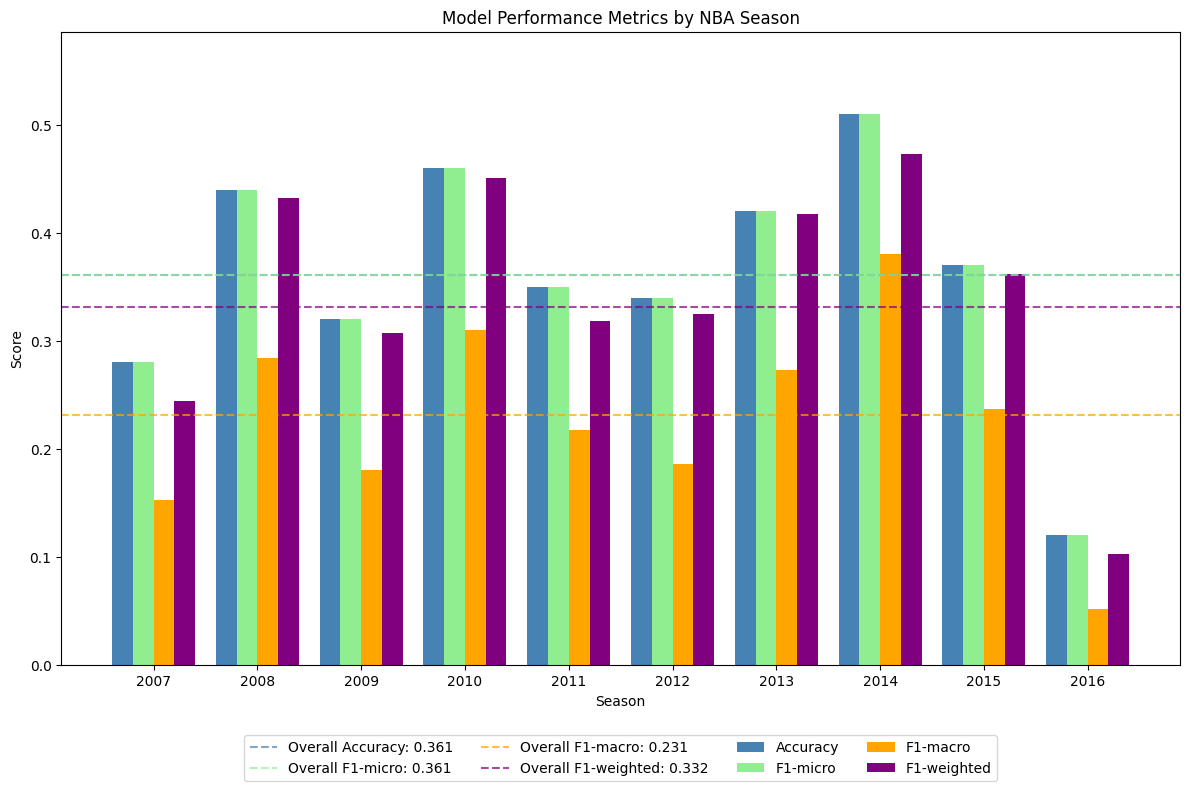

In [28]:
season_metrics = calculate_metrics_by_season(X_test, y_test, rf_model,'rf_modified_dataset.csv','rf_modified_dataset')